In [1]:
## from rpy2 import robjects
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import multiprocessing as mp
import pandas as pd
import numpy as np
import datetime
import yaml
import os
# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# Suppress R warnings in python:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)
rain     = pd.read_csv('haiti-data/proj/rainfall.csv', index_col = 0, parse_dates = True)

compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases', 'C',
                 "VSd", "VRI1d", "VRI2d", "VRI3d", "VRA1d", "VRA2d", "VRA3d",
                 "VSdd", "VRI1dd", "VRI2dd", "VRI3dd", "VRA1dd", "VRA2dd", "VRA3dd",
                 "VSd_alt", "VRI1d_alt", "VRI2d_alt", "VRI3d_alt", "VRA1d_alt", "VRA2d_alt", "VRA3d_alt",
                 "VSdd_alt", "VRI1dd_alt", "VRI2dd_alt", "VRI3dd_alt", "VRA1dd_alt", "VRA2dd_alt", "VRA3dd_alt"]

departements = ['Artibonite','Centre','Grande_Anse','Nippes','Nord','Nord-Est','Nord-Ouest','Ouest','Sud','Sud-Est']

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,20)

index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')

class DeptData():
    def __init__(self):
        self.q05 = pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = compartments)
        self.q50 = pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = compartments)
        self.q95 = pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = compartments)
class VaccinationScenario():
    def __init__(self, course_year, percent_completely_unvaccinated, percent_onedose, percent_twodoses, ve, not_dep = []):
        pop = {'Artibonite':1727524,
        'Centre':746236,
        'Grande_Anse':468301,
        'Nippes':342525,
        'Nord':1067177,
        'Nord-Est':393967,
        'Nord-Ouest':728807,
        'Ouest':4029705,
        'Sud':774976,
        'Sud-Est':632601}
        ocv_order = ['Centre', 'Artibonite','Ouest','Nord-Ouest','Nord','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']
        self.t_vacc_start = {}
        self.t_vacc_end = {}
        self.p1d_reg = {}
        self.r_v_year = {}
        self.ve = ve
        self.not_dep = not_dep

        #20% completely unvaccinated, 10% one-dose only, 70% two doses
        t_init = datetime.date(2019,1,12)
        days_per_departement = int((course_year*365)/len(ocv_order))

        for i, dp in enumerate(ocv_order):
            if dp not in not_dep:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = percent_onedose/(percent_onedose + percent_twodoses)
                self.r_v_year[dp] = pop[dp]*(100-percent_completely_unvaccinated)/100/days_per_departement * 365.25

            else:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = 0
                self.r_v_year[dp] =0
def run_sim():
    # see second answer of https://stackoverflow.com/questions/25175530/can-rpy2-code-be-run-in-parallel on why it starts different 
    # R instances
    all_data = {}

    for dp in departements:
        all_data[dp] = DeptData()


    r_source = robjects.r['source'];
    dept_data = {}
    r_options = robjects.r['options']
    r_options(warn=-1)
    robjects.r('scenario     <- "' + scenario_str + '"')
    robjects.r('nsim         <- '  + str(nsim))
    robjects.r('t_vacc_start <- list()')
    robjects.r('t_vacc_end <- list()')
    robjects.r('p1d_reg <- list()')
    robjects.r('r_v_year <- list()')


    for dp in departements:
        robjects.r('t_vacc_start${} <- "'.format(dp.replace('-','_')) + str(scenario.t_vacc_start[dp]) + '"')
        robjects.r('t_vacc_end${}   <- "'.format(dp.replace('-','_')) + str(scenario.t_vacc_end[dp]) + '"')
        robjects.r('p1d_reg${}     <- '.format(dp.replace('-','_'))  + str(scenario.p1d_reg[dp]))
        robjects.r('r_v_year${}     <- '.format(dp.replace('-','_'))  + str(scenario.r_v_year[dp]))
    robjects.r('cases_ext    <- ' + str(scenario.ve))
    r_source('/Users/chadi/Documents/phd/haiti-ocv-pomp/scripts/forecast_all_dept.R')
    temp = robjects.r['sim_stochastic']
    
    for dp in departements:
        for comp in compartments:
            all_data[dp].q05[comp] = temp[temp['variable'] == comp + dp.replace('-','_')][temp['isdata']=='simulation']['q05'].values
            all_data[dp].q50[comp] = temp[temp['variable'] == comp + dp.replace('-','_')][temp['isdata']=='simulation']['q50'].values
            all_data[dp].q95[comp] = temp[temp['variable'] == comp + dp.replace('-','_')][temp['isdata']=='simulation']['q95'].values
    return all_data

scenarios_df = pd.read_csv('haiti-data/scenarios.csv', index_col = 0)

scenarios = {}
for sid, row in scenarios_df.iterrows():
    not_dep = []
    course_year = 2
    if (row['Roll-out'] == 2):
        not_dep = ['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']
    elif (row['Roll-out'] == 3):
        course_year = 5
    elif (row['Roll-out'] == 4):
        not_dep = ['Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']
        
    percent_completely_unvaccinated = 0
    percent_onedose = 0
    percent_twodoses = 0
    
    if (row['Coverage'] == 1):
        percent_completely_unvaccinated = 20
        percent_onedose = 10
        percent_twodoses = 70
    elif (row['Coverage'] == 2):
        percent_completely_unvaccinated = 40
        percent_onedose = 20
        percent_twodoses = 40
    elif (row['Coverage'] == 3):
        percent_completely_unvaccinated = 3.33
        percent_onedose = 1.67
        percent_twodoses = 95
    ve = row['VE']
            
    #if (row['Priority'] == 1):
    if True:
        scenarios['S' + str(sid)] = VaccinationScenario(course_year, 
                                                      percent_completely_unvaccinated, 
                                                      percent_onedose, 
                                                      percent_twodoses,
                                                      ve,
                                                      not_dep)

S0 = VaccinationScenario(50, 
                         99.9999999, 
                         0.00000001, 
                         0.00,
                         ve = 1)
scenarios['S0'] = S0
    
nsim = 500

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


#### Forecasting with no vaccination

In [124]:
scenario_str = 'S0'
scenario = scenarios[scenario_str]

all_data = run_sim()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
R[write to console]: Parsed with column specification:
cols(
  date = col_date(format = ""),
  Artibonite = col_double(),
  Centre = col_double(),
  Grande_Anse = col_double(),
  Nippes = col_double(),
  Nord = col_double(),
  `Nord-Est` = col_double(),
  `Nord-Ouest` = col_double(),
  Ouest = col_double(),
  Sud = col_double(),
  `Sud-Est` = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  date = col_date(format = ""),
  A

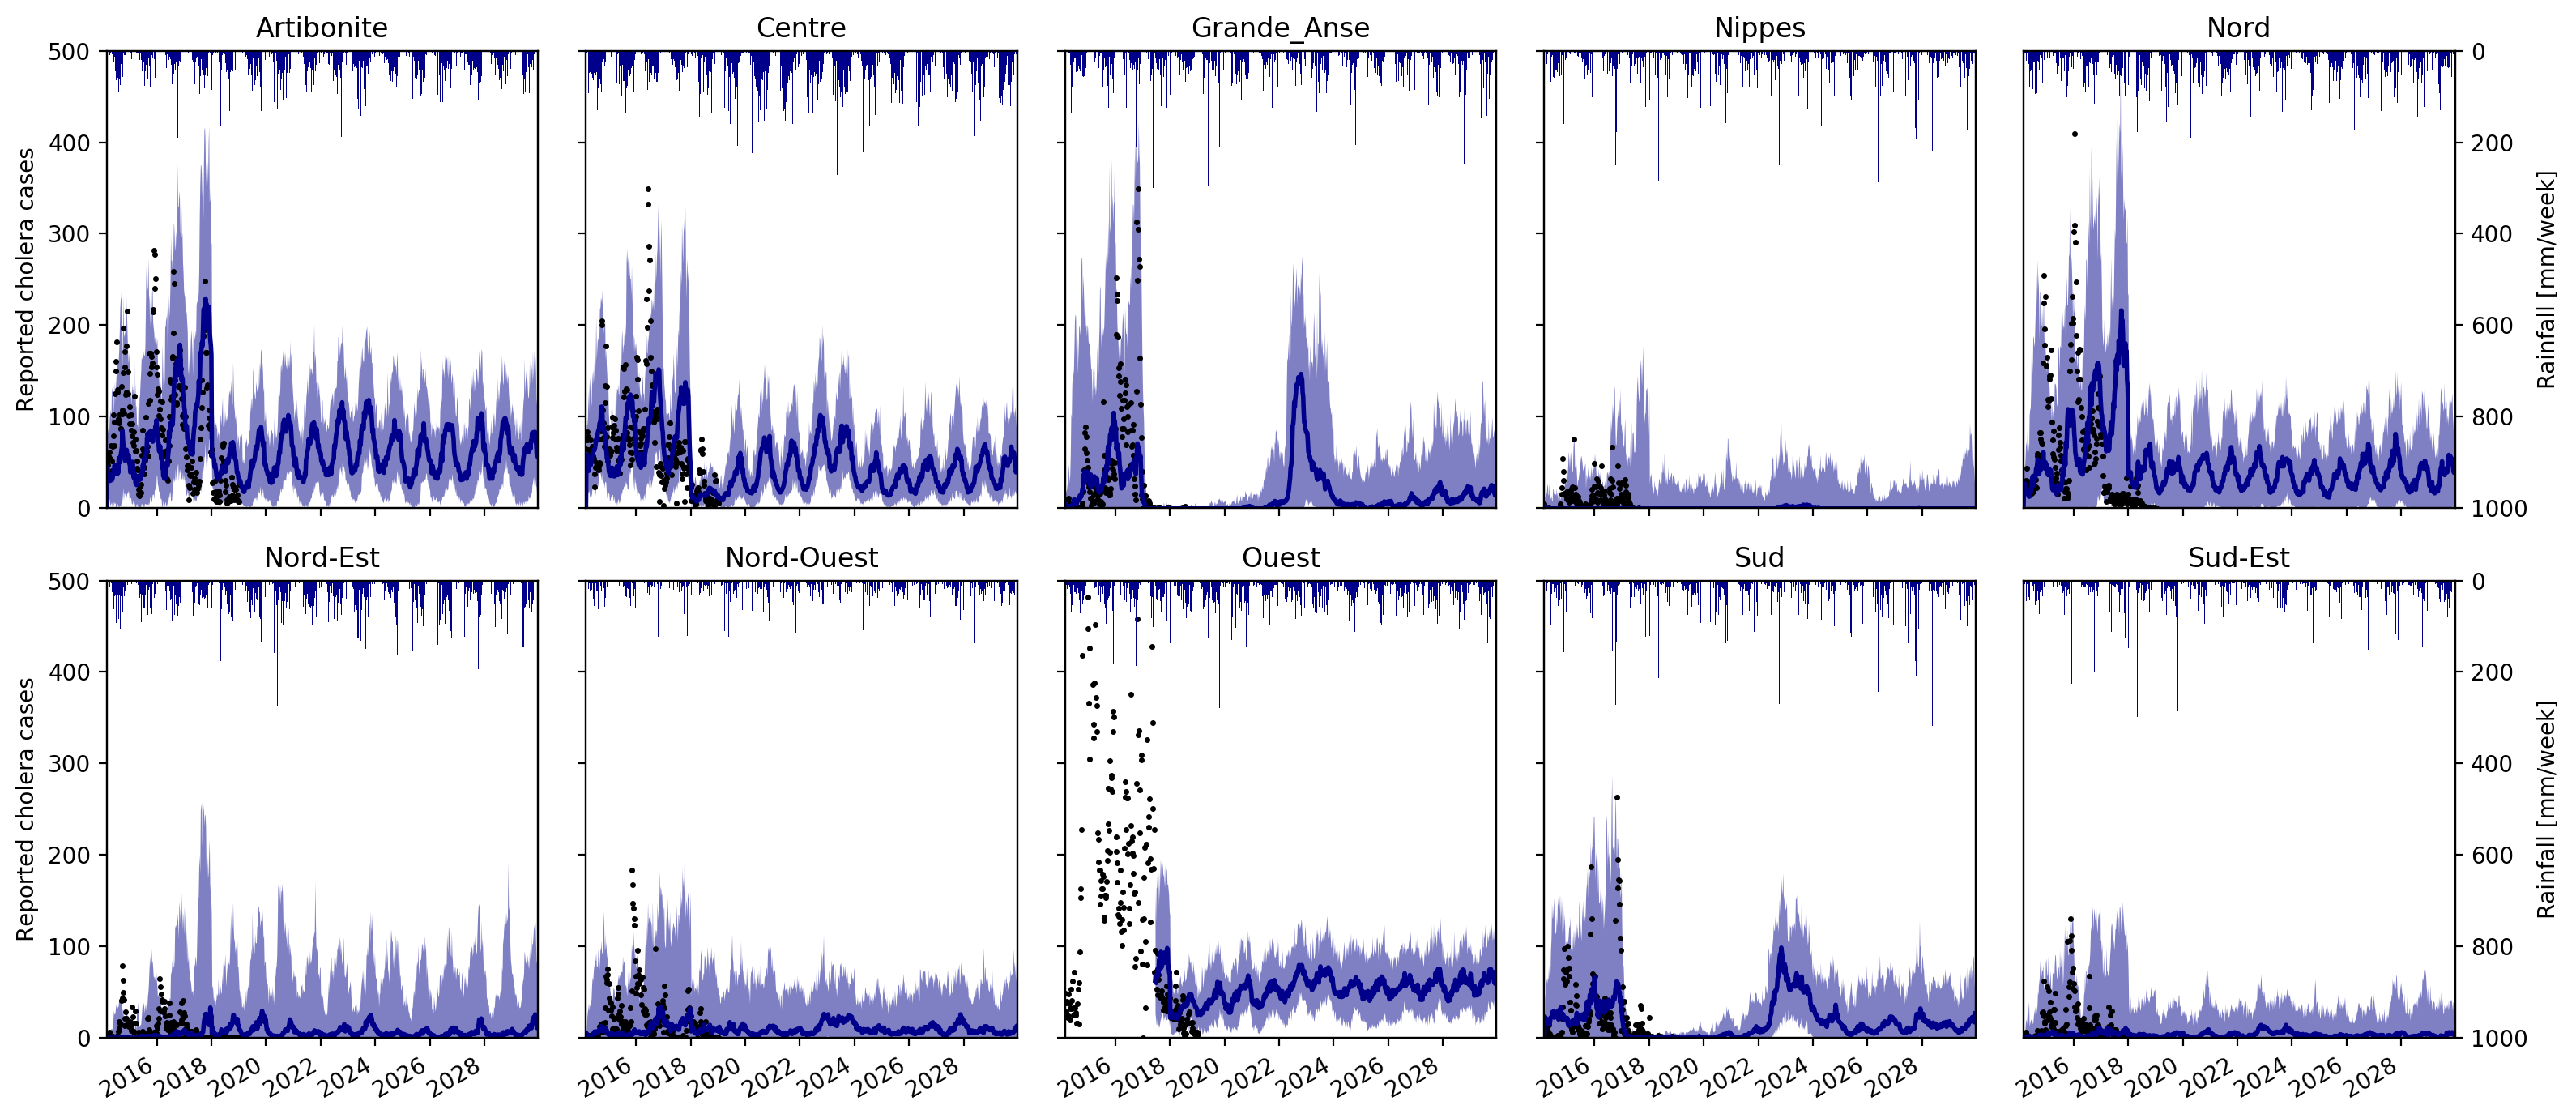

In [129]:
ti = input_parameters['t_start']
tf = input_parameters['t_end']
tf = t_for

all_data['Ouest'].q05['cases'][:datetime.date(2017,6,10)] = np.nan
all_data['Ouest'].q50['cases'][:datetime.date(2017,6,10)] = np.nan
all_data['Ouest'].q95['cases'][:datetime.date(2017,6,10)] = np.nan



fig, axes = plt.subplots((len(dept_avail))//5, 5, figsize=(16,7), squeeze = True, dpi = 200 , sharex='col', sharey='row');
fig.patch.set_facecolor('white')
axes = axes.flat;
for i, dp in enumerate(departements):

    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:][ti:tf], marker='.', linestyle='-',color='black', linewidth=0, markersize=3 ) 
    axes[i].fill_between(all_data[dp].q05['cases'][ti:tf].index, all_data[dp].q05['cases'][ti:tf], all_data[dp].q95['cases'][ti:tf], alpha = .5, color = 'darkblue', linewidth = 0)
    axes[i].plot(all_data[dp].q50['cases'][ti:tf], alpha = 1,linestyle='-', linewidth = 2, color = 'darkblue')
    axt.bar(pd.date_range(ti,tf, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[ti:tf], label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0, 500)
    axt.set_ylim(1000, 0)
    #axt.set_ylim(4*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    if i%5 == 4:
        axt.set_ylabel('Rainfall [mm/week]')
        axes[i].get_yaxis().set_visible(False)
        
    elif i%5 == 0:
        axes[i].set_ylabel('Reported cholera cases')
    if i%5 != 4:
        axt.get_yaxis().set_visible(False)
    #axes[i].legend()
    
for ax in axes:
    ax.label_outer()

fig.autofmt_xdate()
fig.tight_layout()

### Repartition in the differents compartiments for one departement 

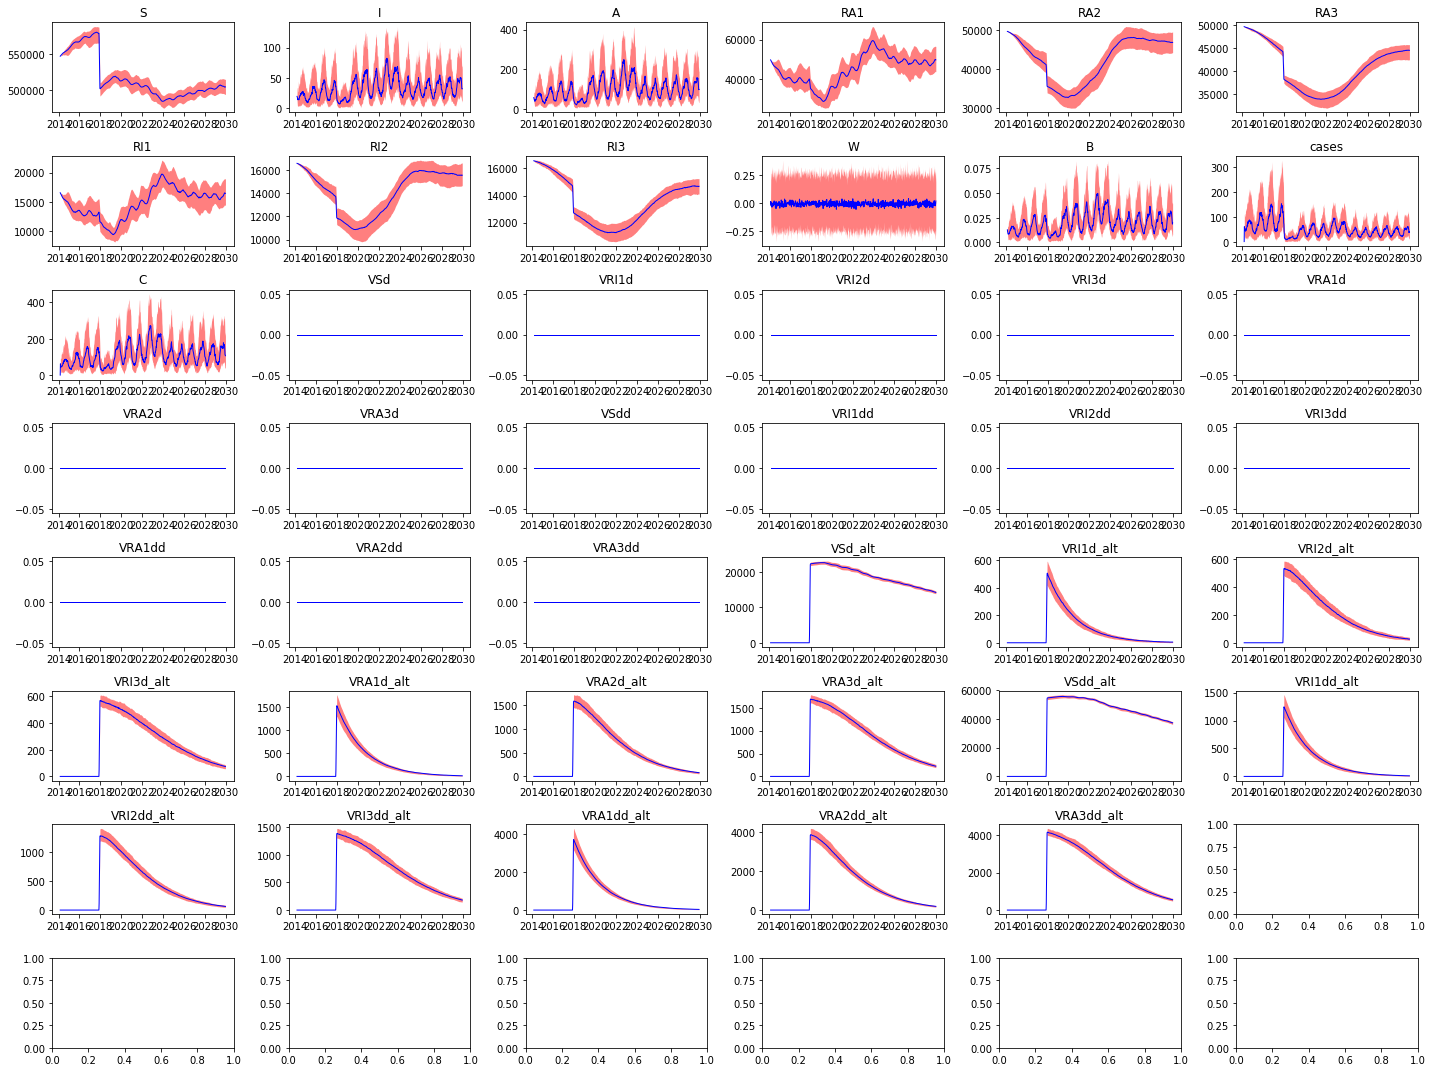

In [109]:
dp = 'Centre'
ti = input_parameters['t_start']
tf = input_parameters['t_end']
tf = t_for
fig, axes = plt.subplots((len(compartments))//5, 6, figsize=(20,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp].q05[comp][ti:tf].index, all_data[dp].q05[comp][ti:tf], all_data[dp].q95[comp][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp].q50[comp][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    
fig.tight_layout()

In [136]:
to_plot = all_data_vacc_mob
plot_all_q50 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = departements)

plot_all_q05 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = departements)

plot_all_q95 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start,
                                      end = t_for, freq = 'W-SAT'), columns = departements)

for dp in dept_avail:
            plot_all_q50[dp] = to_plot[dp].q50['cases']
            plot_all_q95[dp] = to_plot[dp].q95['cases']
            plot_all_q05[dp] = to_plot[dp].q05['cases']

plot_all = pd.concat([plot_all_q05.sum(axis=1), plot_all_q50.sum(axis=1), plot_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95'])


ti = input_parameters['t_start']
ti = datetime.date(2015,7,1)
tf = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots(1, 1, figsize=(10,6), squeeze = True, dpi = 200);
fig.patch.set_facecolor('white')
axt =  axes.twinx()
axes.plot(cases.sum(axis=1)[t_start:][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=5 ) 
axes.fill_between(plot_all['q05'][ti:tf].index, plot_all['q05'][ti:tf], plot_all['q95'][ti:tf], alpha = .5, color = 'blue', linewidth = 0)
axes.plot(plot_all['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 3, color = 'darkblue')
axt.bar(pd.date_range(ti,tf, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[ti:tf], label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

axes.set_ylim(0)
axt.set_ylim(4*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
axes.set_xlim(ti, tf)

start = mdates.date2num(scenario.t_vacc_start['Centre'])
end = mdates.date2num(scenario.t_vacc_end['Grande_Anse'])
end = mdates.date2num(scenario.t_vacc_end['Artibonite']) # For S2


width = end - start
rect = Rectangle((start, 0), width, 100+max(plot_all['q95'][ti:tf]), color='orange', alpha= 0.1)
axes.add_patch(rect) 
axes.add_artist(rect)
rx, ry = rect.get_xy()
cx = rx + rect.get_width()/2.0
cy = ry + rect.get_height()/1.5
    
#fig.tight_layout()
fig.autofmt_xdate()
axt.set_ylabel('Rainfall [mm/week]')
axes.set_ylabel('Reported cholera cases')

NameError: name 'all_data_vacc_mob' is not defined

In [139]:
scenario_str = 'S1'
scenario = scenarios[scenario_str]

all_data_vacc_mob = run_sim()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
R[write to console]: Parsed with column specification:
cols(
  date = col_date(format = ""),
  Artibonite = col_double(),
  Centre = col_double(),
  Grande_Anse = col_double(),
  Nippes = col_double(),
  Nord = col_double(),
  `Nord-Est` = col_double(),
  `Nord-Ouest` = col_double(),
  Ouest = col_double(),
  Sud = col_double(),
  `Sud-Est` = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  date = col_date(format = ""),
  A

TypeError: 'DeptData' object is not subscriptable

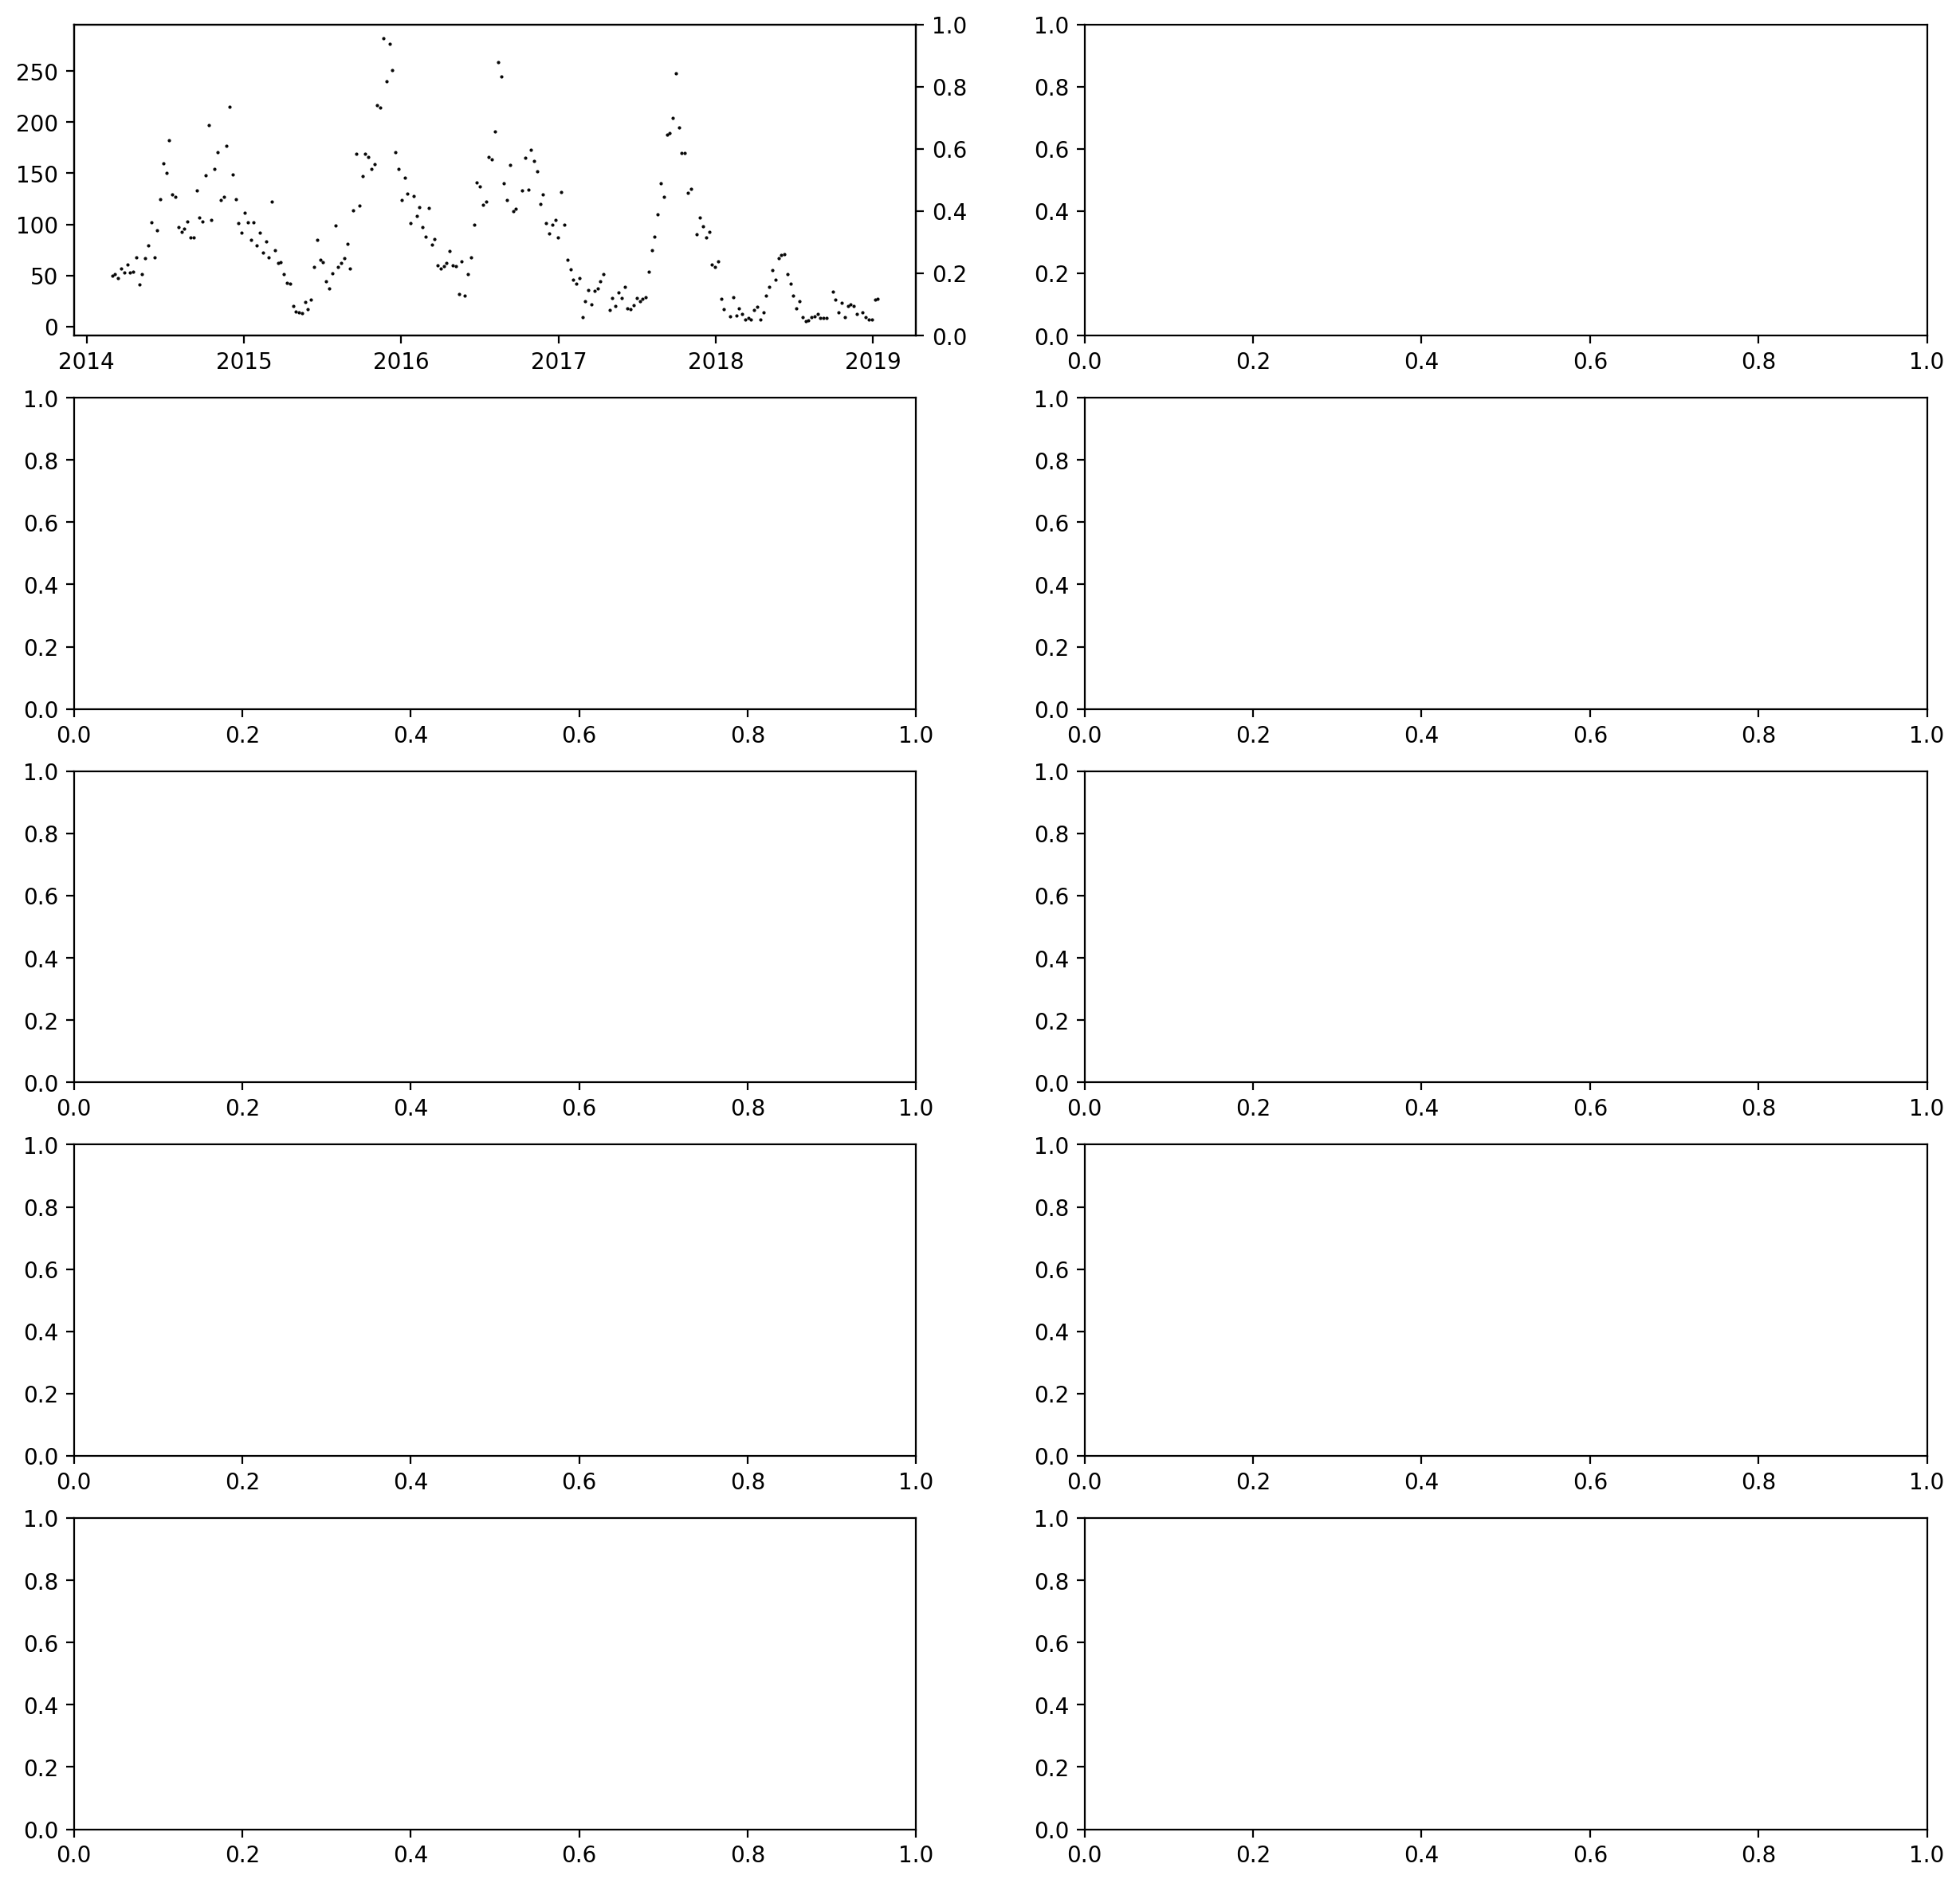

In [141]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,15), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc_mob[dp]['cases']['q05'][ti:tf].index, all_data_vacc_mob[dp]['cases']['q05'][ti:tf], all_data_vacc_mob[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc_mob[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)
    
    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    if dp not in scenario.not_dep:
        # convert to matplotlib date representation
        start = mdates.date2num(scenario.t_vacc_start[dp])
        end = mdates.date2num(scenario.t_vacc_end[dp])
        width = end - start
        rect = Rectangle((start, 0), width, 1000+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
        axes[i].add_patch(rect) 
        axes[i].add_artist(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/1.5

fig.tight_layout()

### Vaccination without mobility to build the mobility file

# PLOT FOR PRESENTATION

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


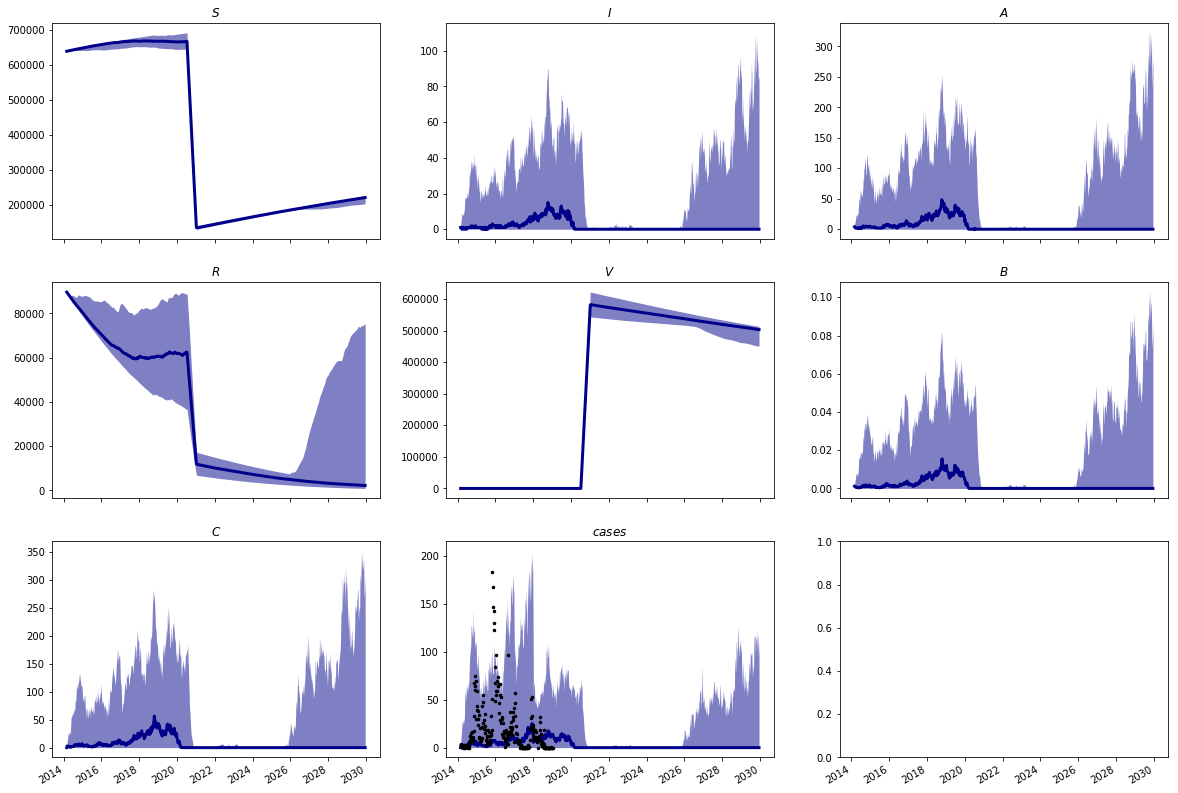

In [432]:
dp = 'Nord-Ouest'
ti = input_parameters['t_start']
tf = input_parameters['t_end']
tf = t_for
data_to_summarize = all_data_vacc_mob

ri_comp = ['RI1', 'RI2', 'RI3']
ra_comp = ['RA1', 'RA2', 'RA3']

data_summary = {}
data_summary['S'] = data_to_summarize[dp]['S']
data_summary['I'] = data_to_summarize[dp]['I']
data_summary['A'] = data_to_summarize[dp]['A']
data_summary['R'] =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = ['q05', 'mean', 'q50', 'q95'])
data_summary['V'] =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = ['q05', 'mean', 'q50', 'q95'])
                                                              
data_summary['B'] = data_to_summarize[dp]['B']
data_summary['C'] = data_to_summarize[dp]['C']
data_summary['cases'] = data_to_summarize[dp]['cases']


for i, comp in enumerate(compartments):
    if 'V' in comp:
        data_summary['V'] += data_to_summarize[dp][comp]
    if comp in ri_comp or comp in ra_comp:
        data_summary['R'] += data_to_summarize[dp][comp]




fig, axes = plt.subplots(3, 3, figsize=(20,15), squeeze = True, sharex = True);
axes = axes.flatten();
i = 0
for key, value in data_summary.items():
    axes[i].fill_between(data_summary[key]['q05'][ti:tf].index, 
                         data_summary[key]['q05'][ti:tf], 
                         data_summary[key]['q95'][ti:tf], alpha = .5, color = 'darkblue', linewidth = 0)
    axes[i].plot(data_summary[key]['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 3, color = 'darkblue')
    if key == 'cases':
        axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=5 ) 




    axes[i].set_title('$' + key + '$')
    i += 1
    #axes[i].legend()
    #axes[i].set_ylim(0)
fig.autofmt_xdate()



S1
S4
S3
S2
S5
0.125
0.125
0.125
0.125
0.125
S6
S8
S7
S9
S10
0.125
0.125
0.125
0.125
0.125
S11
S12
S13
S15
0.125
S14
0.3333333333333333
0.125
0.3333333333333333
0.3333333333333333
S16
S17
S18
S19
S20
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.3333333333333333
S21
0.3333333333333333
S22
S23
S24
0.3333333333333333
0.3333333333333333
S25
S26
S27
0.3333333333333333
0.3333333333333333
0.017275266370125168
0.017275266370125168
0.017275266370125168
S28
S29
S31
S30
S32
0.017275266370125168
0.017275266370125168
0.017275266370125168
0.017275266370125168
0.017275266370125168
S33
S34
S35
S36
S0
0.017275266370125168
0.017275266370125168
0.017275266370125168
1.0
0.017275266370125168


In [142]:
def lol(scenario_str):
    print(scenario_str)
    print(scenarios[scenario_str].p1d_reg['Artibonite'])